## Import Libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
%matplotlib inline
fig = plt.figure(figsize = (18,10))

<Figure size 1296x720 with 0 Axes>

## Import Datasets

In [2]:
train = pd.read_csv('train_titanic.csv')
test = pd.read_csv('test_titanic.csv')

## Data Preperation 

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
pd.isna(train).sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
pd.isna(test).sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### The Cabin Column has too much data to work with so we will drop that column. Age has a decent amount missing as well but we will try to impute those numbers because it may be useful.

In [7]:
train.drop(columns= ['Cabin'], inplace= True)
test.drop(columns= ['Cabin'], inplace= True)

### List of columns we are keeping

In [8]:
columns = train.columns
columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

## Feature Creation

#### SibSp is # of Siblings / Spouses aboard the Titanic.
#### Parch is # of Parents / Children aboard the Titanic

In [9]:
train['SibSp'].max()

8

In [10]:
train['Parch'].max()

6

In [11]:
train['FamilyMembers'] = train['SibSp'] + train['Parch'] 
test['FamilyMembers'] = test['SibSp'] + test['Parch'] 

In [12]:
train['Alone'] = train.apply(lambda x: 1 if x.FamilyMembers==0 else 0,axis =1)
test['Alone'] = test.apply(lambda x: 1 if x.FamilyMembers==0 else 0,axis =1)

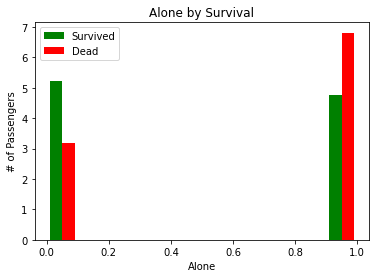

In [13]:
plt.hist(x = [train[train['Survived']==1]['Alone'], train[train['Survived']==0]['Alone']], density=True,histtype='bar', color = ['g','r'],label = ['Survived','Dead'])
plt.title('Alone by Survival')
plt.xlabel('Alone')
plt.ylabel('# of Passengers')
plt.legend()

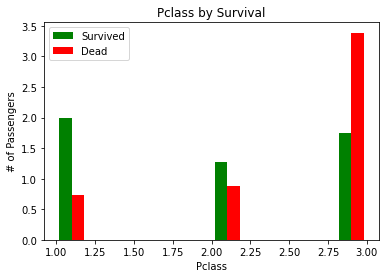

In [14]:
plt.hist(x = [train[train['Survived']==1]['Pclass'], train[train['Survived']==0]['Pclass']], density=True,histtype='bar', color = ['g','r'],label = ['Survived','Dead'])
plt.title('Pclass by Survival')
plt.xlabel('Pclass')
plt.ylabel('# of Passengers')
plt.legend()

#### Pclass shows a strong correlation with survival rate. Pclass = 3 is more likely to die and Pclass = 1 is more likely to Survive

### Extract passenger's title or prefix from the name attribute.

In [15]:
train['Prefix'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test['Prefix'] = test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

### Extract passenger's second name from the name attribute.
##### Dropped this attribute later because it proved to be irrelevent.

In [16]:
train['Pname']= train.Name.str.extract('.*\((.*)\).*')
test['Pname']= test.Name.str.extract('.*\((.*)\).*')

### Display the counts aswell as frequency of survival rate based on prefix

In [17]:
pd.crosstab(train['Prefix'], train['Survived'])

Survived,0,1
Prefix,,
Capt,1,0
Col,1,1
Countess,0,1
Don,1,0
Dr,4,3
Jonkheer,1,0
Lady,0,1
Major,1,1
Master,17,23


In [18]:
pd.crosstab(train['Prefix'], train['Survived'], normalize='index')

Survived,0,1
Prefix,,
Capt,1.000000,0.000000
Col,0.500000,0.500000
Countess,0.000000,1.000000
Don,1.000000,0.000000
Dr,0.571429,0.428571
Jonkheer,1.000000,0.000000
Lady,0.000000,1.000000
Major,0.500000,0.500000
Master,0.425000,0.575000


### Use prefixs to estimate age of passengers with missing value.

In [19]:
uncommon = ['Sir', 'Lady', 'Capt', 'Don','Dona', 'Jonkheer', 'Major', 'Col', 'Rev', 'Dr','Countess']
common = ['Mr','Mrs','Miss','Master']

In [20]:
train['Prefix'] = train['Prefix'].replace('Mlle', 'Miss')
train['Prefix'] = train['Prefix'].replace('Ms', 'Miss')
train['Prefix'] = train['Prefix'].replace('Mme', 'Mrs')

In [21]:
test['Prefix'] = test['Prefix'].replace('Mlle', 'Miss')
test['Prefix'] = test['Prefix'].replace('Ms', 'Miss')
test['Prefix'] = test['Prefix'].replace('Mme', 'Mrs')

In [22]:

means = {}
for i in uncommon:
    if(train[train['Prefix']==i]['Age'].count()>0):
        means[i] = train[train['Prefix']==i]['Age'].sum()/train[train['Prefix']==i]['Age'].count()
means

{'Sir': 49.0,
 'Lady': 48.0,
 'Capt': 70.0,
 'Don': 40.0,
 'Jonkheer': 38.0,
 'Major': 48.5,
 'Col': 58.0,
 'Rev': 43.166666666666664,
 'Dr': 42.0,
 'Countess': 33.0}

In [23]:
for i in common:
    means[i] = train[train['Prefix']==i]['Age'].sum()/train[train['Prefix']==i]['Age'].count()
means

{'Sir': 49.0,
 'Lady': 48.0,
 'Capt': 70.0,
 'Don': 40.0,
 'Jonkheer': 38.0,
 'Major': 48.5,
 'Col': 58.0,
 'Rev': 43.166666666666664,
 'Dr': 42.0,
 'Countess': 33.0,
 'Mr': 32.368090452261306,
 'Mrs': 35.788990825688074,
 'Miss': 21.845637583892618,
 'Master': 4.574166666666667}

In [24]:
train['Age'] = train.apply(lambda x: means[x.Prefix] if pd.isna(x.Age) else x.Age,axis =1)

In [25]:
test['Age'] = test.apply(lambda x: means[x.Prefix] if pd.isna(x.Age) else x.Age,axis =1)

### Create Feature Age_Band which bins ages to create a categorical feature.
#### This feature was tuned many times. I changed bin sizes and number of bins to get the graph and model score higher.

In [26]:
train['Age_Band'] = pd.cut(train['Age'], bins=[0,12,20,55,110], labels=['Child','Teen','Adult','Elder'])

In [27]:
test['Age_Band'] = pd.cut(test['Age'], bins=[0,12,20,55,110], labels=['Child','Teen','Adult','Elder'])

In [28]:
train['Prefix'] = train['Prefix'].replace(uncommon, 'uncommon')
test['Prefix'] = test['Prefix'].replace(uncommon, 'uncommon')

In [29]:
pd.crosstab(train['Prefix'], train['Survived'], normalize='index')

Survived,0,1
Prefix,,
Master,0.425000,0.575000
Miss,0.297297,0.702703
Mr,0.843327,0.156673
Mrs,0.206349,0.793651
uncommon,0.652174,0.347826


In [30]:
pd.crosstab(train['Prefix'], train['Survived'])

Survived,0,1
Prefix,,
Master,17,23
Miss,55,130
Mr,436,81
Mrs,26,100
uncommon,15,8


### There is a strong correletion between Sex of Passenger and survival rate. Females were far more likely to survive then males.

In [31]:
pd.crosstab(train['Sex'], train['Survived'], normalize='index')

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


In [32]:
train.Fare.max()

512.3292

In [33]:
train.Fare.min()

0.0

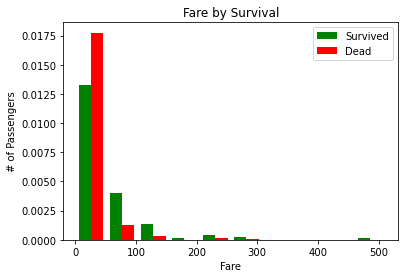

In [34]:
plt.hist(x = [train[train['Survived']==1]['Fare'], train[train['Survived']==0]['Fare']], density=True,histtype='bar', color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare by Survival')
plt.xlabel('Fare')
plt.ylabel('# of Passengers')
plt.legend()

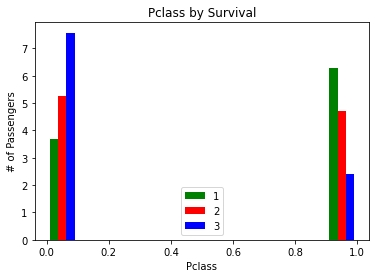

In [35]:
plt.hist(x = [train[train['Pclass']==1]['Survived'], train[train['Pclass']==2]['Survived'], train[train['Pclass']==3]['Survived']], density=True,histtype='bar', color = ['g','r','b'],label = ['1','2','3'])
plt.title('Pclass by Survival')
plt.xlabel('Pclass')
plt.ylabel('# of Passengers')
plt.legend()

In [36]:
test['Fare'].fillna(0,inplace=True)

In [37]:
train['Fare_Band'] = pd.cut(train['Fare'], bins=[-1,0,30,70,110,300,600], labels=['Zero','Low','Low-Mid','Mid','Mid-High','High'])

In [38]:
test['Fare_Band'] = pd.cut(test['Fare'], bins=[-1,0,30,70,110,300,600], labels=['Zero','Low','Low-Mid','Mid','Mid-High','High'])

#### There is a Strong Correlation between Fare_Band and Survival. At fare of 0 the survival rate is extremely low, 93% die. As Fare goes the survival rate increases

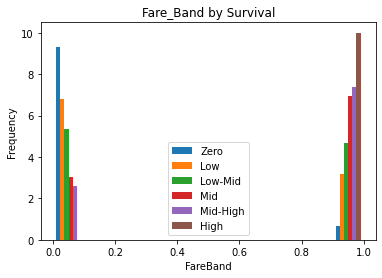

In [39]:
plt.hist(x = [train[train['Fare_Band']=='Zero']['Survived'], train[train['Fare_Band']=='Low']['Survived'], train[train['Fare_Band']=='Low-Mid']['Survived'],train[train['Fare_Band']=='Mid']['Survived'],train[train['Fare_Band']=='Mid-High']['Survived'],train[train['Fare_Band']=='High']['Survived']], density=True,histtype='bar',label = ['Zero','Low','Low-Mid','Mid','Mid-High','High'])
plt.title('Fare_Band by Survival')
plt.xlabel('FareBand')
plt.ylabel('Frequency')
plt.legend()

In [40]:
pd.crosstab(train['Fare_Band'], train['Survived'], normalize='index')

Survived,0,1
Fare_Band,,
Zero,0.933333,0.066667
Low,0.680685,0.319315
Low-Mid,0.534884,0.465116
Mid,0.303571,0.696429
Mid-High,0.260870,0.739130
High,0.000000,1.000000


In [41]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilyMembers,Alone,Prefix,Pname,Age_Band,Fare_Band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,Mr,NaN,Adult,Low
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,0,Mrs,Florence Briggs Thayer,Adult,Mid
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,1,Miss,NaN,Adult,Low
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,0,Mrs,Lily May Peel,Adult,Low-Mid
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,1,Mr,NaN,Adult,Low


## Check for missing values in datasets

In [42]:
pd.isna(train).sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Embarked           2
FamilyMembers      0
Alone              0
Prefix             0
Pname            748
Age_Band           0
Fare_Band          0
dtype: int64

In [43]:
pd.isna(test).sum()

PassengerId        0
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Embarked           0
FamilyMembers      0
Alone              0
Prefix             0
Pname            340
Age_Band           0
Fare_Band          0
dtype: int64

## Encode


In [44]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'FamilyMembers', 'Alone',
       'Prefix', 'Pname', 'Age_Band', 'Fare_Band'],
      dtype='object')

In [45]:
to_encode = ['Pclass','Sex','Fare_Band','Age_Band','FamilyMembers','Alone','Prefix','Embarked']

In [46]:
le = LabelEncoder()
for i in to_encode:
    train[i] = le.fit_transform(train[i])
    test[i] = le.transform(test[i])

## Visualize

In [47]:
features =['Pclass','Sex','Fare_Band','Age_Band','FamilyMembers','Alone','Prefix','Embarked','Age','Fare']

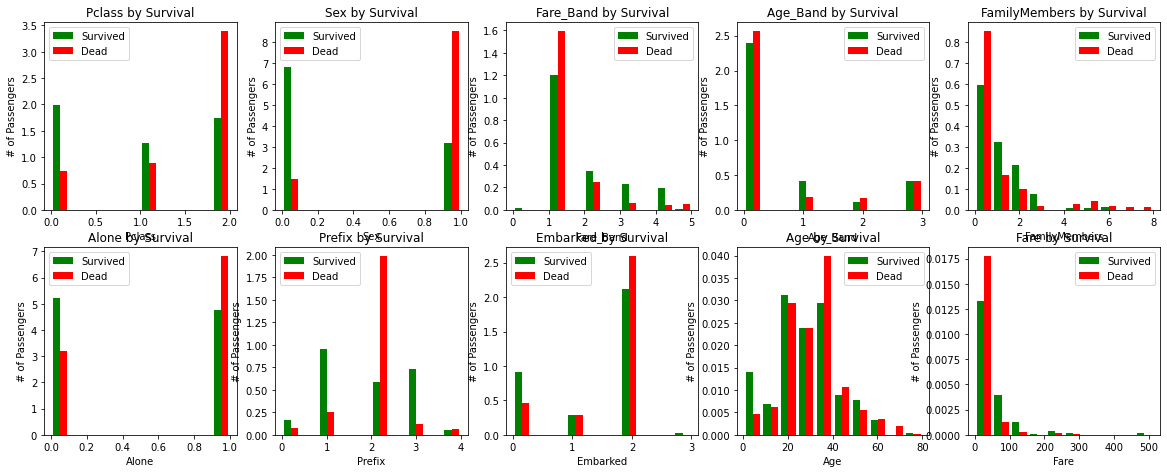

In [48]:
fig = plt.figure(figsize = (20,20))
i=1
for row in features:
    fig.add_subplot(5,5,i)
    plt.hist(x = [train[train['Survived']==1][row], train[train['Survived']==0][row]], density=True,histtype='bar', color = ['g','r'],label = ['Survived','Dead'])
    plt.title(row+' by Survival')
    plt.xlabel(row)
    plt.ylabel('# of Passengers')
    plt.legend()
    i+=1


## Normalize

In [49]:
scaler = StandardScaler()
train_X = scaler.fit_transform( train[features])
test_X = scaler.transform( test[features])

## PCA

In [50]:
from sklearn.decomposition import PCA
pca = PCA()
x_pca = pca.fit_transform(train_X)
x_pca = pd.DataFrame(x_pca)
x_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.651360,0.899386,1.114195,0.192207,-0.400463,-0.668587,-0.282318,0.255257,-0.557172,-0.816312
1,3.005683,-1.488933,0.231464,-1.649600,0.593665,-0.221085,-0.883312,-0.274296,-0.261900,-0.114358
2,-1.102959,0.691384,-0.313215,-0.680322,-0.676221,1.733848,0.228134,-0.139264,0.428723,-0.180892
3,1.882438,-0.944110,1.439334,-0.204187,0.560553,1.053286,-0.351620,0.144961,-0.941080,-0.096915
4,-1.637941,-0.540708,0.276400,0.285113,-0.455367,-0.056478,0.079837,0.150567,0.349501,-0.135661


In [51]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.25402896, 0.21794336, 0.11773543, 0.09701616, 0.08745298,
       0.08053263, 0.04407001, 0.04138308, 0.03864227, 0.02119511])

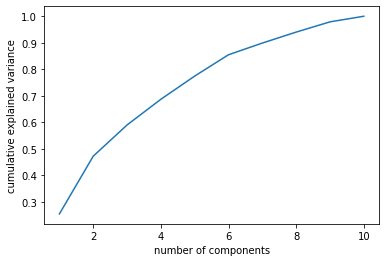

In [52]:
plt.plot([1,2,3,4,5,6,7,8,9,10], np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [53]:
test_pca = pca.transform(test_X)
test_features = pd.DataFrame(test_pca)

## Feature Selection

Model Selection

In [54]:
y=train['Survived']
train.drop(columns= ['Survived'], inplace=True)

In [55]:
X = x_pca

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

## Random Forest Classification

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score,recall_score,accuracy_score
clf = RandomForestClassifier(
    criterion='entropy',
    n_jobs = -1,
    random_state=25,
    n_estimators=1000,
    min_samples_split=25,
    oob_score=True)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
best_preds = predictions

In [58]:
print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.8350978135788263
Recall = 0.825
Accuracy = 0.8283582089552238


In [59]:
clf.feature_importances_

array([0.17496967, 0.07109951, 0.08210108, 0.13154235, 0.07437695,
       0.23816149, 0.05475447, 0.04616582, 0.08012547, 0.04670318])

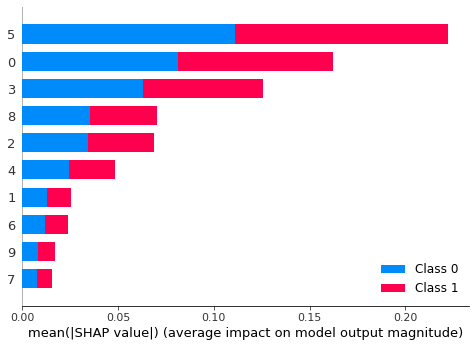

In [60]:
import shap
shap_values = shap.TreeExplainer(clf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score,recall_score,accuracy_score
clf = RandomForestClassifier(
    criterion='entropy',
    n_jobs = -1,
    random_state=25,
    n_estimators=1000,
    min_samples_split=25,
    oob_score=True)
clf.fit(X_train[[5,3,0,2,8,4]], y_train)
predictions = clf.predict(X_test[[5,3,0,2,8,4]])
best_preds = predictions


In [62]:
print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.8389292196007259
Recall = 0.8334821428571428
Accuracy = 0.835820895522388


## XGBoost Classification

In [63]:
import xgboost as xgb

In [64]:
D_train = xgb.DMatrix(X_train[[5,3,0,2,8,4]], label=y_train)
D_test = xgb.DMatrix(X_test[[5,3,0,2,8,4]], label=y_test)

In [65]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob', 
    'num_class': 3}

steps = 5

In [66]:
model = xgb.train(param, D_train, steps)

[17:08:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [67]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.8168386491557224
Recall = 0.8015625
Accuracy = 0.8059701492537313


In [68]:
param = {
    'eta': 0.01, 
    'max_depth': 4,  
    'num_parallel_tree':64,
    'objective': 'multi:softprob',  
    'num_class': 3} 
steps = 200 

model = xgb.train(param, D_train, steps)
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

[17:08:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precision = 0.8444444444444444
Recall = 0.8321428571428571
Accuracy = 0.835820895522388


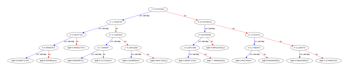

In [69]:
xgb.plot_tree(model,num_trees=0)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

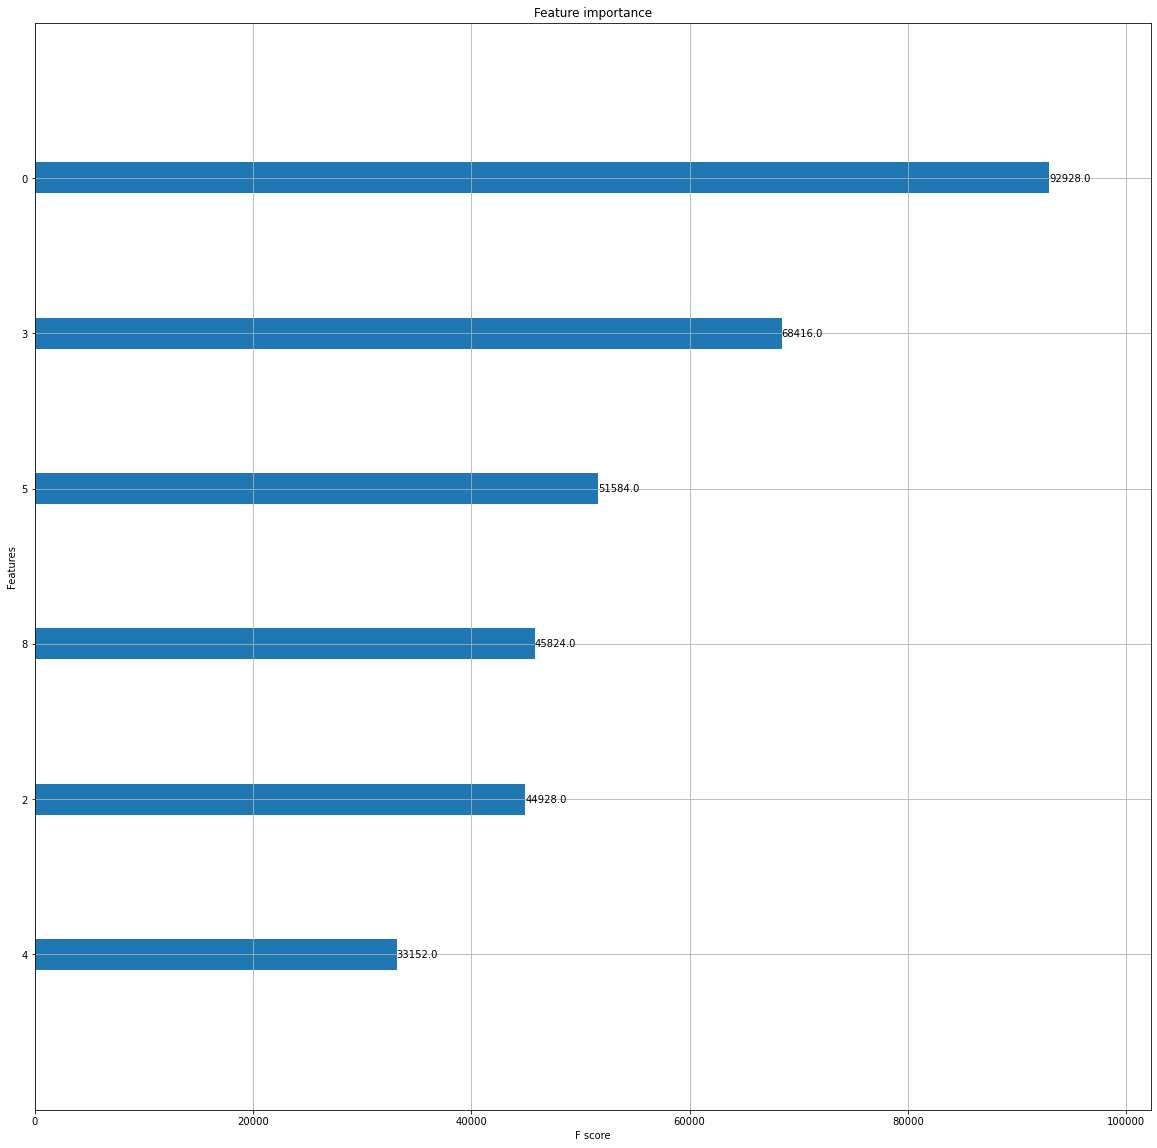

In [70]:
xgb.plot_importance(model)

In [71]:
from xgboost import XGBClassifier

model=xgb.XGBClassifier(num_parallel_tree=15,random_state=1,learning_rate=0.001)
model.fit(X_train[[5,3,0,2,8,4]], y_train)
best_preds = model.predict(X_test[[5,3,0,2,8,4]])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:08:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precision = 0.7866256550467077
Recall = 0.7808035714285715
Accuracy = 0.7835820895522388


## Logistic Regression

In [72]:
from sklearn.linear_model import LogisticRegression

In [73]:
logreg = LogisticRegression(random_state=5).fit(X_train[[5,3,0,2,8,4]], y_train)

In [74]:
predictions = logreg.predict(X_test[[5,3,0,2,8,4]])
best_preds = predictions

In [75]:
print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.8042577675489068
Recall = 0.7950892857142857
Accuracy = 0.7985074626865671


## KNN

In [76]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

In [77]:
neigh.fit(X_train[[5,3,0,2,8,4]], y_train)
predictions = neigh.predict(X_test[[5,3,0,2,8,4]])
best_preds = predictions

In [78]:
print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.8350978135788263
Recall = 0.825
Accuracy = 0.8283582089552238


## Write predicitons to Submission File

### Using Random Forest Classifier to predict the values.

In [79]:
preds = clf.predict(test_features[[5,3,0,2,8,4]])

In [80]:
y_pred_frame = pd.DataFrame()
y_pred_frame['Survived'] = preds
y_pred_frame.index = np.arange(892, len(preds)+892)
y_pred_frame.index.name = 'PassengerId'

In [81]:
y_pred_frame.to_csv('submission.csv', sep=',')

## Kaggle Submission yields a .78947 accuracy.

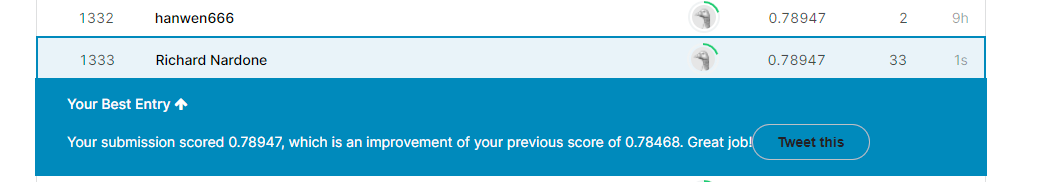

In [82]:
from IPython.display import Image
Image(filename='Titanic Kaggle Submission.png')